# Import dataset

In [1]:
import tensorflow as tf
tf.random.set_seed(10)
import random
random.seed(10)
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
# from PIL import Image, ImageEnhance

In [2]:
data_dir = 'dataset/'
img_height = 72
img_width = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir + 'train/',
  seed=128,
  image_size=(img_height, img_width))

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir + 'validation/',
  seed=128,
  image_size=(img_height, img_width))

train_dataset = []
for i in range(180):
    train_dataset.append(tf.keras.utils.image_dataset_from_directory(
    f'dataset/train_{i}/',
    seed=128,
    image_size=(img_height, img_width)))

pretrain_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir + 'pretrain/',
  seed=123,
  image_size=(img_height, img_width))

def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)
pretrain_ds = train_ds.map(normalize)
for i in range(180):
    train_dataset[i] = train_dataset[i].map(normalize)

Found 36000 files belonging to 4 classes.
Found 4000 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classes.
Found 200 files belonging to 4 classe

# Pretrain CNN model

In [3]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(72, 128, 3)),
    tf.keras.layers.Conv2D(16, (11, 11), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (9, 9), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (5, 5), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# model.summary()

In [4]:
pretrain_history = model.fit(pretrain_ds, epochs=10, batch_size=32)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.6797 - loss: 0.7200
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9071 - loss: 0.2472
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9526 - loss: 0.1366
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9681 - loss: 0.0930
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9749 - loss: 0.0742
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9788 - loss: 0.0616
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9819 - loss: 0.0536
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9859 - loss: 0.0407
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9880 - loss: 0.0350
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9881 - loss: 0.0379


dict_keys(['accuracy', 'loss'])


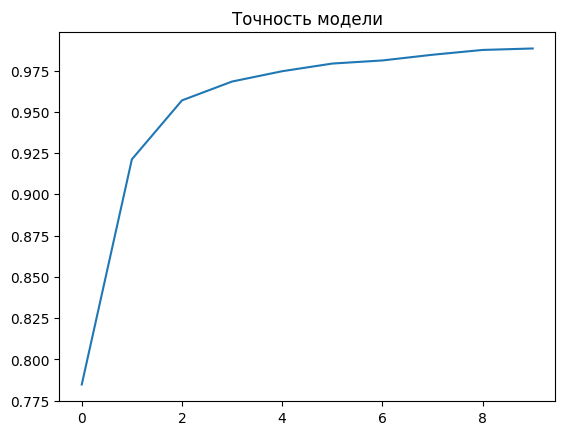

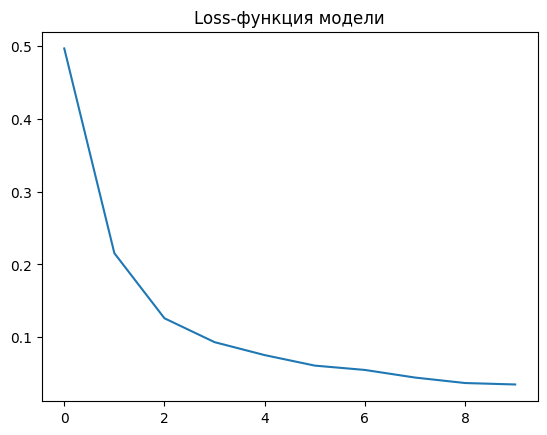

In [14]:
# print(pretrain_history.history.keys())
plt.plot(pretrain_history.history['accuracy'])
plt.title('Точность модели')
plt.show()
plt.plot(pretrain_history.history['loss'])
plt.title('Loss-функция модели')
plt.show()

In [6]:
model.save_weights('./weights/pretrained_weights.weights.h5')

In [4]:
model.load_weights('./weights/pretrained_weights.weights.h5')

C:\Users\SlothMaster\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [5]:
val_loss, val_acc = model.evaluate(val_ds)
print('Accuracy on pretrained model:', val_acc)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7295 - loss: 325.1315
Accuracy on pretrained model: 0.7210000157356262


# Fine-tuning by optimizers

In [4]:
for i in range(7):
    model.layers[i].trainable = False

optimizers = ['adam', 'sgd', 'lion', 'loss_scale_optimizer']

for i in range(len(optimizers)):
    model.load_weights('./weights/pretrained_weights.weights.h5')
    model.optimizer = optimizers[i]
    history = model.fit(train_ds, epochs=5, batch_size=32)
    plt.plot(history.history['accuracy'])
    plt.title('Точность модели')
    plt.show()
    plt.plot(pretrain_history.history['loss'])
    plt.title('Loss-функция модели')
    plt.show()
    model.save_weights('./weights/' + optimizers[i] + '.weights.h5')
    val_loss, val_acc = model.evaluate(val_ds)
    print('Accuracy on model fine-tuned by optimizer ' + optimizers[i] + ':', val_acc)

Epoch 1/5


C:\Users\SlothMaster\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


AttributeError: 'str' object has no attribute 'scale_loss'

# Fine-tuning by GA

In [4]:
def weights_to_list(weights):
    plist = []
    for i in range(32):
        plist.extend(weights[8][i])
    plist.extend(weights[9])
    return plist

def list_to_weights(weights):
    for i in range(32):
        arr = []
        for j in range(4):
            arr.append(weights[i * 4 + j])
        pretrained_weights[8][i] = np.array(arr, dtype="float32")
    pretrained_weights[9] = np.array(weights[-4:], dtype="float32")
    return pretrained_weights

In [6]:
random.seed(32)

def accuracy(w):
    model.set_weights(list_to_weights(w))
    # test_loss, test_accuracy1 = model.evaluate(train_dataset[random.randint(0, 179)], verbose=None)
    # test_loss, test_accuracy2 = model.evaluate(train_dataset[random.randint(0, 179)], verbose=None)
    # test_loss, test_accuracy3 = model.evaluate(train_dataset[random.randint(0, 179)], verbose=None)
    # test_loss, test_accuracy4 = model.evaluate(train_dataset[random.randint(0, 179)], verbose=None)
    # test_loss, test_accuracy5 = model.evaluate(train_dataset[random.randint(0, 179)], verbose=None)
    # return (test_accuracy1 + test_accuracy2 + test_accuracy3 + test_accuracy4 + test_accuracy5) / 5
    test_loss, test_accuracy = model.evaluate(train_ds, verbose=None)
    return test_accuracy

def genetic_algorithm(first_individual, population_size, n_iterations, silent = False):

    P_CROSSOVER = 0.9
    P_MUTATION = 0.3
    ELITE = 2
    T = 0.4

    population = []
    max_fit = []
    avg_fit = []

    for i in range(population_size):
        individual = deepcopy(first_individual)
        if i != 0:
            for j in range(len(first_individual)):
                if random.random() < 75 / len(first_individual):
                    individual[j] += 0.5 * random.random() - 0.25
        population.append(individual)

    with tqdm(total=n_iterations, disable = silent) as pbar:
        for k in range(n_iterations):
            population = sorted(population, key=lambda x: -accuracy(x))
            max_fit.append(accuracy(population[0]))

            offsprings = []
            offsprings.extend(population[:ELITE])
            for i in range(ELITE, population_size):
                r = random.randint(0, round(T * population_size))
                offsprings.append(deepcopy(population[r]))

            for i in range(ELITE, population_size // 2 + ELITE // 2):
                if random.random() < P_CROSSOVER:
                    parent1 = offsprings[i]
                    parent2 = offsprings[i + population_size // 2 - ELITE // 2]
                    for gene in range(len(parent1)):
                        if random.random() < 0.5:
                            parent1[gene], parent2[gene] = parent2[gene], parent1[gene]

            for i in range(ELITE, population_size):
                if random.random() < P_MUTATION:
                    for gene in range(len(offsprings[i])):
                        if random.random() < 0.1:
                            if gene < 128:
                                offsprings[i][gene] = 0.5 * random.random() - 0.25
                            else:
                                offsprings[i][gene] = 5 * random.random() - 2.5
            population = offsprings
            pbar.update(1)
    population = sorted(population, key=lambda x: -accuracy(x))
    return population[0], max_fit

C:\Users\SlothMaster\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
100%|████████████████████████████████████████████████████████████████████████████| 120/120 [10:15:48<00:00, 307.91s/it]


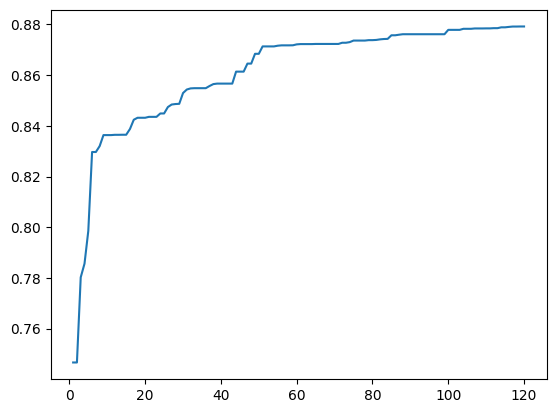

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8752 - loss: 67.7286
Accuracy on test dataset: 0.8794999718666077


In [7]:
model.load_weights('./weights/pretrained_weights.weights.h5')
pretrained_weights = model.get_weights()

best_ind, max_fit = genetic_algorithm(weights_to_list(pretrained_weights), 30, 120)

t = list(range(1, len(max_fit) + 1))
plt.plot(t, max_fit)
plt.show()

model.set_weights(list_to_weights(best_ind))

val_loss, val_acc = model.evaluate(val_ds)
print('Accuracy on test dataset:', val_acc)

In [8]:
model.save_weights('./weights/ga.weights.h5')

In [10]:
model.load_weights('./weights/adam.weights.h5')
_, a1 = model.evaluate(val_ds)
w1 = weights_to_list(model.get_weights())
model.load_weights('./weights/sgd.weights.h5')
_, a2 = model.evaluate(val_ds)
w2 = weights_to_list(model.get_weights())
model.load_weights('./weights/lion.weights.h5')
_, a3 = model.evaluate(val_ds)
w3 = weights_to_list(model.get_weights())
model.load_weights('./weights/loss_scale_optimizer.weights.h5')
_, a4 = model.evaluate(val_ds)
w4 = weights_to_list(model.get_weights())
model.load_weights('./weights/ais.weights.h5')
_, a5 = model.evaluate(val_ds)
w5 = weights_to_list(model.get_weights())

 15/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9160 - loss: 0.1625

C:\Users\SlothMaster\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9392 - loss: 0.1874
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9637 - loss: 0.1264
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9759 - loss: 0.1403
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9691 - loss: 0.1239
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8376 - loss: 51.4139


In [11]:
print(round(a1, 7), round(a2, 7),  round(a3, 7), round(a4, 7), round(a5, 7))
for i in range(len(w1)):
    print(i + 1, round(w1[i], 7), round(w2[i], 7), round(w3[i], 7), round(w4[i], 7), round(w5[i], 7))

0.94075 0.9605 0.972 0.9665 0.83875
1 0.1740902 0.1378221 0.145884 0.1764043 -0.0718834
2 0.0799827 0.0827754 0.1119516 0.0144589 -0.1906312
3 0.2036318 0.1859769 0.1574943 0.2182437 0.1894505
4 -0.3001158 -0.2587448 -0.356381 -0.2975291 0.0217256
5 0.2758373 0.2440641 0.2758373 0.2758373 -0.0671041
6 -0.3157152 -0.3158202 -0.3157152 -0.3157152 -0.0476052
7 -0.0320156 -0.0002541 -0.0320156 -0.0320156 -0.1108268
8 -0.2669009 -0.2914216 -0.2669009 -0.2669009 -0.0942732
9 -0.0055488 -0.0849945 -0.0052849 -0.0289192 0.0672435
10 -0.4289195 -0.3669181 -0.42315 -0.4366158 0.1365218
11 0.0852216 0.0351862 0.0618492 0.0584834 0.13046
12 0.0540836 0.1508881 0.0457613 0.068414 -0.1910662
13 -0.2813458 -0.206226 -0.2813458 -0.2813458 0.1881474
14 0.0728036 -0.0221862 0.0728036 0.0728036 -0.1567714
15 0.2677622 0.2984346 0.2677622 0.2677622 0.2082031
16 0.1133933 0.0596838 0.1133933 0.1133933 0.2030183
17 -0.2718324 -0.2322204 -0.2387142 -0.2817002 0.1914052
18 0.0515656 0.0181125 0.0561307 0.0947

In [45]:
def min_and_max(lst):
    print(min(lst[:128]), max(lst[:128]), min(lst[128:]), max(lst[128:]))

min_and_max(w1)
min_and_max(w2)
min_and_max(w3)
min_and_max(w4)
min_and_max(w5)

-0.25836742